# Проект

## <span style="color: DarkRed;">Информация о представленном решении</span>
<ul>
    <li>
        Представленный алгоритм выполняет постройку объектов 3 типов: <b>жилых домов</b>, <b>дорог</b> и <b>парков</b>. Решение состоит из <b>5</b> основных этапов. Именно: <b>ввод данных в программу</b> (1 этап), <b>расположение на доступном для строительства участке 3 типов объектов</b> (этапы 2-4), <b>визуализация конечного результата и формирование выходного файла</b> (этап 5)
    </li>
    <li>
        Для решения задачи использовались в том числе следующие библиотеки: <b>geopandas</b> и <b>shapely</b> для эффективной работы с геометрическими объектами; <b>networkx</b> - для прокладки новых дорог к домам
    </li>
    <li>
        В качестве системы координат в данной программе используется проекция <b>Web Mercator (EPSG:3857)</b>
    </li>
    <li>
        Алгоритм предполагает ввод дополнительных данных с клавиатуры. В тех местах, где это потребуется, даны подробные объяснения, какие именно параметры ожидает получить программа, и для чего они нужны. Кроме того, предъявляются определенные требоваия к входному .geojson-файлу, которые также будут приведены.
    </li>
    <li>
        К написанному коду прилагаются соответствующие комментарии с объяснением производимых операций
    </li>
</ul>


In [35]:
# загрузка всех необходимых библиотек
import geopandas as gpd
import shapely
from shapely.geometry import Point, Polygon, LineString
from shapely.affinity import rotate
from shapely.geometry import box
from shapely import distance, intersection, MultiPoint
from shapely.ops import nearest_points, unary_union
import numpy as np
import random
import networkx as nx
import copy
import math
import matplotlib.pyplot as plt

## <span style="color: DarkBlue;">Этап 1. Загрузка данных об участке в программу</span>

### <span style="color: DarkRed;">В каком формате ожидаются входные данные в файле .geojson</span>
* Ожидается, что у всех разрешенных участков не будет пометки 'restriction': 'no_build'
* Считается, что все дороги имеют пометку 'name': 'Дорога'

<Axes: >

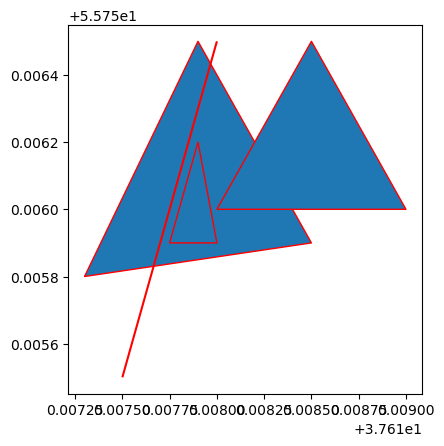

In [5]:
# загрузка данных из файла и применение проекции EPSG:3857
df = gpd.read_file('sample.geojson').to_crs(3857)

df.to_crs(4326).plot(edgecolor='red')

## <span style="color: DarkBlue;">Этап 2. Расположение домов на участке, доступном для строительства</span>

### <span style="color: DarkRed;">Краткое описание алгоритма размещения жилых домов</span>
* Данный алгоритм решает задачу о <b>типовой застройке</b>. Ожидается, что девелопер хочет застроить заданный участок прямоугольными домами известного размера. При этом, если потребуется, данный алгоритм нетрудно модифицировать так, чтобы он застривал участок прямоугольниками различных размеров
* Представленный алгоритм является стохастическим
* Гарантируется, что дома не будут выходить за границы участка или перекрываться с дорогами и запрещенными зонами
* Хотя в условии задачи сказано лишь, что площадь жилой застройки не должна превышать определенного процента от площади доступной зоны, данный алгоритм стремится добиться постройки максимального возможного количества домов - имеет место <b>оптимизация</b>. При этом требование по максимальной плотности застройки строго соблюдается
* Требование по минимальному расстоянию между домами, естественно, соблюдается

### <span style="color: DarkRed;"> Как работает алгоритм размещения жилых домов</span>
* На доступном участке задается квадратная сетка с шагом, равным наименьшей стороне прямоугольника
* Полученные узлы сетки перемешиваются, чтобы более равномерно распределить дома по территории
* Для каждого узла создается прямоугольник с заданными размерами
* Если прямоугольник не может поместиться в доступную зону или находится к другим домам ближе, чем должен, то начинаются повороты этого прямоугольника вокруг центра с определенным шагом и в диапазоне углов от 0 до 180 градусов. Как только расположение доступно, дом располагается в данной позиции и происходит переход к следующим ячейкам
* Цикл прерывается, если ограничения по плотности больше не позволяют расположить ни одного дома
* Оптимизация производится следующим образом: производится несколько попыток (выставленное количество - 10) застроить участок домами. Выбирается вариант, в рамках которого была застроена наибольшая возможная площадь - то есть наибольшее количество домов

<span style="color: DarkRed;">2.1.</span> Сначала необходимо произвести некоторые манипуляции с полученными геометрическими данными, чтобы вычленить территорию, доступную для застройки, дороги и запрещенные зоны. Вокруг дорог, границ участка и запрещенных зон создается буфферная зона, в которой дома строиться не должны. Величины отступа можно выбирать гибко

In [7]:
# Отдельно выделяем дороги. Нам это понадобится в будущем
roads = df[(df['name'] == 'Дорога')]
ROADS = roads.geometry.union_all().buffer(2)

In [9]:
# Теперь выделяем прочие зоны, у которых есть пометка "no_build"
restricted_zones = df[(df['restriction'] == 'no_build') & (df['name'] != 'Дорога')].geometry.union_all()

In [11]:
# Из допустимых для строительства зон убираем все пересечения с запретными зонами
available_area = df[(df['restriction'] != 'no_build')]
available_area = available_area.geometry.difference(restricted_zones)
AVAILABLE_AREA = available_area.geometry.union_all()
AVAREA = available_area
del restricted_zones

In [13]:
# Определение внешних границ всех присутствующих в файле геометрий. Построение общей геометрической области задачи
minx, miny, maxx, maxy = df.total_bounds
TOTAL_ZONE = Polygon([[minx, miny], [minx, maxy], [maxx, maxy], [maxx, miny], [minx, miny]]).buffer(1)

In [15]:
# В запрещенные зоны для строительства домов входят не только территории с пометкой "no_build", но и территории вне разрешенного участка
RESTRICTED_ZONES = TOTAL_ZONE.difference(AVAILABLE_AREA).buffer(3)

<Axes: >

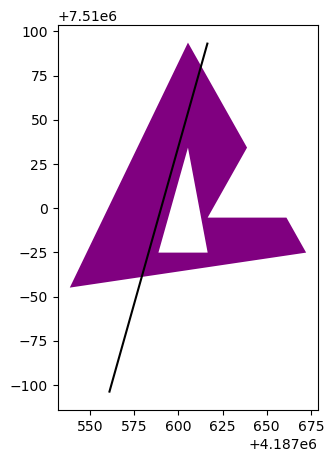

In [17]:
# Промежуточная изуализация доступной для строительства зоны и имеющихся дорог
fig, ax = plt.subplots(1, figsize =(5, 5))
available_area.plot(ax=ax, facecolor='purple')
roads.plot(ax=ax, edgecolor='black')

<span style="color: DarkRed;">2.2.</span> Это функция, которая будет создавать прямоугольники заданного размера и поворачивать их на требуемый угол

In [20]:
# In:
# point - центр прямоугольника в виде объекта shapely.geometry.Point
# height, width - стороны прямоугольника
# angle - угол поворота

#Out: повернутый прямоугольник shapely.geometry.Polygon

def create_rectangle(point, height, width):
    x = point.x
    y = point.y
    return box(x - width / 2, y - height / 2, x + width / 2, y + height / 2)

<span style="color: DarkRed;">2.3.</span> Эта функция создает сетку

In [22]:
# In:
# bounds - границы описанного вокруг участка застройки прямоугольника
# cell_size - размер шага сетки
#Out: сетка

def create_grid(bounds, cell_size):
    xmin, ymin, xmax, ymax = bounds
    points = []
    for x in np.arange(xmin+cell_size/2, xmax-cell_size/2, cell_size):
        for y in np.arange(ymin+cell_size/2, ymax-cell_size/2, cell_size):
            point = Point(x, y)
            if point.within(AVAILABLE_AREA): 
                points.append(point)
    return points

<span style="color: DarkRed;">2.4.</span> Собственно функция, которая управляет процессом застройки участка домами

In [24]:
# In:
# size_of_rect - размеры прямоугольника дома или парка
# restricts - словарь с ограниченяими на расстояние и на допустимую макисмальную площадь жилых домов
#Out: 
# buildings - массив построенных домов

def generate_buildings(size_of_rect, restricts, points):
    placed_area = 0
    area_of_building = size_of_rect[0] * size_of_rect[1]
    buildings = []
    area_bound = restricts['max_area'] - area_of_building
    random.shuffle(points) #перемешиваем, чтобы более равномерно раскидать дома
    for point in points:
        if (placed_area > area_bound):
            break
        possible_building = create_rectangle(point, size_of_rect[0], size_of_rect[1])
        for angle in np.arange(0, 180, 18): # 18 - шаг по углам
            possible_building = rotate(possible_building, angle, origin=point)
            if not ((possible_building.intersects(RESTRICTED_ZONES)) | 
                                            (possible_building.intersects(ROADS))):
                 if all(distance(possible_building, other) >= restricts['distance'] for other in buildings):
                     buildings.append(possible_building)
                     placed_area += area_of_building
                     break
    return buildings

<span style="color: DarkRed;">2.5.</span> В этом блоке происходит запуск функций постройки жилых домов

In [27]:
AREA = AVAILABLE_AREA.area # Доступная площадь участка
best_placement = None # расположение с максимальной площадью
max_area = 0 # отслеживается наибольшая площадь застройки
builds_prcntg = 0.5 # процент территории для застройки

size_of_rect = [5., 10.] # размеры дома
restricts = {'distance': 8., 'max_area': builds_prcntg * AREA} # ограничения: 'distance' - минимальное расстояние между домами
                                                        # 'max_area' - максимально доступная площадь для застройки
points = create_grid(available_area.total_bounds, min(size_of_rect)) # создаем сетку
print(len(points))
for _ in range(10):
    buildings = generate_buildings(size_of_rect, restricts, points)
    cur_area = sum(build.area for build in buildings)
    if cur_area > max_area:
        max_area = cur_area
        best_placement = copy.deepcopy(buildings) 

276


<span style="color: DarkRed;">2.6.</span> Функция для создания GeoDataFrame

In [30]:
def to_geoframe(geometry, type):
    features = {
        "type": "Feature",
        "properties": {"type": type},
        "geometry": geometry
    }
    return features

<span style="color: DarkRed;">2.7.</span> Запись и визуализация лучшего решения. На графике представлена доступная территория и дороги, чтобы продемонстрировать, что никакие объекты не перекрываются.

In [37]:
placed_builds = gpd.GeoDataFrame(to_geoframe(unary_union(best_placement), 'residential'))
bld_ter = sum(bld.area for bld in best_placement) / AREA * 100

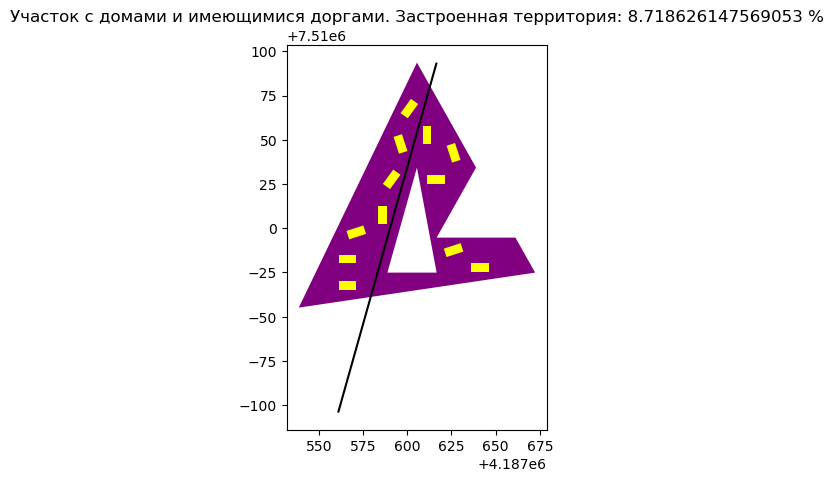

In [41]:
fig, ax = plt.subplots(1, figsize =(5, 5))
available_area.plot(ax=ax, facecolor='purple')
roads.plot(ax=ax, edgecolor='black')
placed_builds.plot(ax=ax, facecolor='yellow')
leg = "Застроенная территория: " + str(bld_ter) + " %"
plt.title("Участок с домами и имеющимися доргами. " + leg)
plt.show()

## <span style="color: blue;">Этап 3. Прокладка новых дорог</span>

### <span style="color: DarkRed;">Как работает алгоритм прокладки дорог</span>
* <b>Во входном файле должна быть хотя бы одна дорога!</b>
* <b>Строительство дорог производится в том числе через территории, находящиеся вне зоны для строительства, исключая обасти с пометкой 'restriction': 'no_build'.</b> В примере из условия задания дорога находилась вне зоны разрешенного строительства. Так что, чтобы проложить новые дороги, необходимо выйти за пределы зоны разрешенного строительства. Из этого и был сделан вывод, что дороги можно прокладывать везде, кроме напрямую запрещенных участков и выстроенных на предыдущем этапе домов
* Предполагается, что новые дороги должны быть соединены с уже имеющимися дорогами. Если во входном файле нет дорог - работа алгоритма может закончиться ошибкой
* В основе данного решения лежит алгоритм поиска оптимального пути между точками <b>A*</b>. Делается это следующим образом.
1. Устанавливается норма, что на определенном расстоянии от дома (гибко задаваемый параметр) должна находиться хотя бы одна дорога. Если это условие не выполняется, то ищутся ближайщие точки у дороги (point_on_road) и у буфферной зоны вокруг дома, внутри которой должна быть хотя бы одна дорога (point_on_buid).
2. Задается сетка. 
3. Для узлов сетки создается граф. Причем ребро между двумя вершинами графа имеется, только если между этими вершинами можно пройти, не пересекая запрещенных зон. <b>Создание ребер графа может быть долгим по повремени процессом!</b> Поэтому сетка создается так, чтобы в графе было только 2000 ячеек, чтобы время вычисления было более или менее приемлемым. Этот параметр можно регулировать в зависимости от вычислительных возможностей. Худший случай для предложенного алгоритма - геометрия с малым количеством препятствий. Максимальное количество ребер тогда может быть 1.990.000. Время вычислений составит около 7 минут. Делалась попытка распараллелить этот процесс, но результат оказался хуже, чем без применения параллельных вычислений.
4. Находятся индексы ближайшие узлов сетки для точек point_on_road и point_on_buid: nearest_to_buid, nearest_to_road
5. Между вершинами графа nearest_to_buid и nearest_to_road запускается алгоритм A*
6. Найденный путь соединяется с точками point_on_road и point_on_buid

<b>Важно отметить:</b>    
a) Препятствия могут быть расположены так, что проведение новой дороги к дому от ближайшей к нему дороги - не самый оптимальный выбор. Хотя  в большинстве случаев это вряд ли будет так.  
b) Потенциально возможна такая геометрия препятствий на плоскости, что ближайшая к point_on_road ячейка сетки не сможет быть соединена с этой точкой, не пересекая запрещенных зон. 
c) Естественно, что чем мельче сетка, тем больше шансов проложить. Если позволяет время, то можно задавать большее количество ячеек - это лучшее решение возможной проблемы из пункта b).

* Для того, чтобы уменьшить уменьшить вероятность возникновения двух перечисленных выше проблем, найденный путь подвергается <b>оптимизации</b>. 
  
1. Алгоритм оптимизации проходит по каждому отрезку найденного пути от конца к началу.
2. Если где-либо расстояние от данного участка дороги до уже существующей дороги составляет меньше определенного расстояния (по умолчанию стоит 50 метров), то производится попытка соединить ближайшую точку уже существующей дороги с данным участком пути. Если новый путь не пересекает запрещенных зон, то за начало оптимизируемого пути принимается найденная ближайшая к отрезку оптимизируемого пути.
3. Если найденный путь пересекает уже существующие дороги, то за начало пути принимается последняя пересеченная дорога.

<span style="color: DarkRed;">3.1.</span> Геометрические манипуляции с целью выделить разрешенные и запрещенные для строительства дорог зоны.

In [43]:
# при прокладке дорог к запрещенной зоне относятся только изначально запретные участки и участки, занятые домами. 
RESTRICTED_ZONES = df[(df['restriction'] == 'no_build') & (df['name'] != 'Дорога')].geometry.union_all().buffer(4)
BUILDS_ZONE = placed_builds.geometry.union_all().buffer(4)
RESTRICTED_ZONES = RESTRICTED_ZONES.union(BUILDS_ZONE)
AVAILABLE_AREA = TOTAL_ZONE.difference(RESTRICTED_ZONES)

<span style="color: DarkRed;">3.2.</span> Задаем сетку

In [46]:
# Разбиваем территорию на 2000 ячеек
GRID_SIZE = math.sqrt(AVAILABLE_AREA.area / 2000)
print(GRID_SIZE)

3.69878272144886


In [48]:
# создание сетки
TOTAL_ZONE = TOTAL_ZONE.buffer(GRID_SIZE)
nodes = create_grid(TOTAL_ZONE.bounds, GRID_SIZE)
NODES = MultiPoint(nodes)
print(len(nodes))

2019


<span style="color: DarkRed;">3.3.</span> Создаем взвешенный граф в реализации networkx

In [51]:
#del G
G = nx.Graph()
for i in range(len(nodes)):
    G.add_node(i)

In [53]:
# добавляем ребра. Ребро между вершинами существует, только если вершины можно соединить прямой линией.
import time

start_time = time.time()
for i in range(len(nodes)):
    #print(i)
    for j in range(i+1, len(nodes)):
        lstr = LineString([nodes[i], nodes[j]])
        if not lstr.intersects(RESTRICTED_ZONES):
            G.add_edge(i, j, weight=lstr.length)
print("--- %s seconds ---" % (time.time() - start_time))
#777562 ребер - 142 секунд с within
#777562 ребер -  114 секунд с intersects

--- 189.5847795009613 seconds ---


In [55]:
print(G.number_of_edges())

849606


<span style="color: DarkRed;">3.4.</span> Эвристическая функция - расстояние между конечной вершиной и той вершиной, где сейчас находится алгоритм A*.

In [58]:
#In:
# node1, node2 - вершины
#Out: 
# расстояние между вершинами

def heuristic(node1, node2):
    return LineString([nodes[node1], nodes[node2]]).length

<span style="color: DarkRed;">3.5.</span> Функция оптимизации пути, про принцип работы которой уже расказывалось выше

In [61]:
#In:
# path - список с индексами узлов сетки
#Out: 
# кортеж из двух элементов - нового начало маршрута и оставшихся точек неоптимизированного пути

def road_optimization(path):
    global GRID_SIZE
    global ROADS
    global RESTRICTED_ZONES
    for i in reversed(range(1,len(path))): # проходим по вновь созданному пути от конца к началу
        cur_lstr = LineString([nodes[path[i-1]], nodes[path[i]]]) # создали прямую линию между узлами
        nearest = nearest_points(ROADS, cur_lstr) # определяем ближаюшую точку к данному отрезку на уже существующих дорогах
        if (0 < nearest[0].distance(nearest[1]) <= 50.): # если в радиусе 50 метров, то пробуем проложить путь к этой точке
            lstr = LineString([nearest[0], nodes[path[i]]])
            if not lstr.intersects(RESTRICTED_ZONES):
                return (nearest[0], path[i:])  # если запрещенные зоны не пересекаем, то получается более оптимальный путь, чем изначально
        inter = cur_lstr.intersection(ROADS) # возможно, что мы пересекли на своем пути существующие дороги
        start = nodes[path[i-1]]  # эта переменная будет хранить в себе начальную точку для случая, 
                                #когда отрезок линии пересекает сразу несколько дорог, чтобы не возникло бесконечного цикла
        while type(inter) != shapely.geometry.linestring.LineString: # если пересечение произошло и оно не является наложением отрезка
                                                                    # на существующую дорогу
            if (type(inter) == shapely.geometry.point.Point):  # если пересечение с одной дорогой
                return (inter, path[i:])  # за начало оптимизируемого пути принимаем эту точку пересечения
            else: # этот блок обрабатывает случай, когда произошло пересечение сразу нескольких дорог
                multi = list(inter.geoms) # записали точки пересечения в список
                tmp = multi[0] # взяли первую точку из списка
                if (tmp == start): # если эта точка совпадает с нынешним началом отрезка,
                    tmp = multi[1] 
                start = tmp  # то берем следующую
                inter = LineString([tmp, nodes[path[i]]]).intersection(ROADS) # снова делаем пересечение, рано или поздно, 
                                                                                # мы попадем в блок обработки единственного пересечения
        else:
            if (str(inter) != 'LINESTRING Z EMPTY'): # если рассматриваемый участок накладывается на существующие дороги,  
                return (None, path[i:])  # то путь начнем с конца данного отрезка
    return (None, path)

<span style="color: DarkRed;">3.6.</span> Функция, управляющая нахождением и оптимизацией пути

In [64]:
#In:
# nearest_to_road, nearest_to_buid - индексы ближайших к концам маршрута ячеек
# point_on_build, point_on_road - точки, между которыми прокладывается путь
#Out: 


def create_road(nearest_to_road, nearest_to_buid, point_on_build, point_on_road, build):
    global ROADS
    global RESTRICTED_ZONES
    path = None
    start = None
    try:
        path = nx.astar_path(G, nearest_to_road, nearest_to_buid, heuristic=heuristic, weight='weight')
    except nx.NetworkXNoPath:  # если путь не удается проложить
        print("Не нашел")
        return
    start, path = road_optimization(path) # запустили оптимизацию
    path = [nodes[nd] for nd in path]  # создали список точек пути на плоскости
    if start != None:  # если было найдено лучшее начало маршрута, то это теперь начало
        path.insert(0, start)
    else:
        if not LineString([point_on_road, path[0]]).intersects(RESTRICTED_ZONES): # не нашли пути лучше -> пытаемся соединить путь с точкой
                                                    # на дороге. Потенциально возможно, что соединить не получится,тогда оставляем как есть
            path.insert(0, point_on_road)
    if ((not LineString([path[-1], point_on_build]).intersects(RESTRICTED_ZONES)) and # соединяем путь с точкой у дома
                not (path[-1].distance(build) > point_on_build.distance(build))): # возможно, что последняя ячейка пути ближе к дому, 
                                                                                        # чем point_on_build, тогда не нужно соединять
            path.append(point_on_build)
    path = LineString(path) # итоговый путь
    ROADS = ROADS.union(path)  # считаем дорогу построенной

In [66]:
# у дорог нет буффера в отличие от предыдущего этапа
del ROADS
ROADS = roads.geometry.union_all().intersection(AVAILABLE_AREA)

<span style="color: DarkRed;">3.7.</span> Поиск пути для тех домов, кому это необходимо

In [69]:
distance_to_road = 5. # норма расстояния от дома до дорог

point_on_road, point_on_build = 0, 0
nearest_to_buid, nearest_to_road = 0, 0
numb = 0
for buid in best_placement:
    tmp = buid.buffer(distance_to_road)  # создали буффер
    if not (tmp.intersects(ROADS)):   
        tmp = tmp.difference(RESTRICTED_ZONES) # выбираем точки только в разрешенных зонах 
        point_on_build, point_on_road = nearest_points(tmp, ROADS) # ближайшие точки двух геометрий
        nearest_to_buid = nodes.index(nearest_points(point_on_build, NODES)[1]) # индексы ближайших ячеек сетки
        nearest_to_road = nodes.index(nearest_points(point_on_road, NODES)[1])
        create_road(nearest_to_road, nearest_to_buid, point_on_build, point_on_road, buid) # запускаем строительство дорог
    numb += 1

<span style="color: DarkRed;">3.8.</span> Вот что получилось

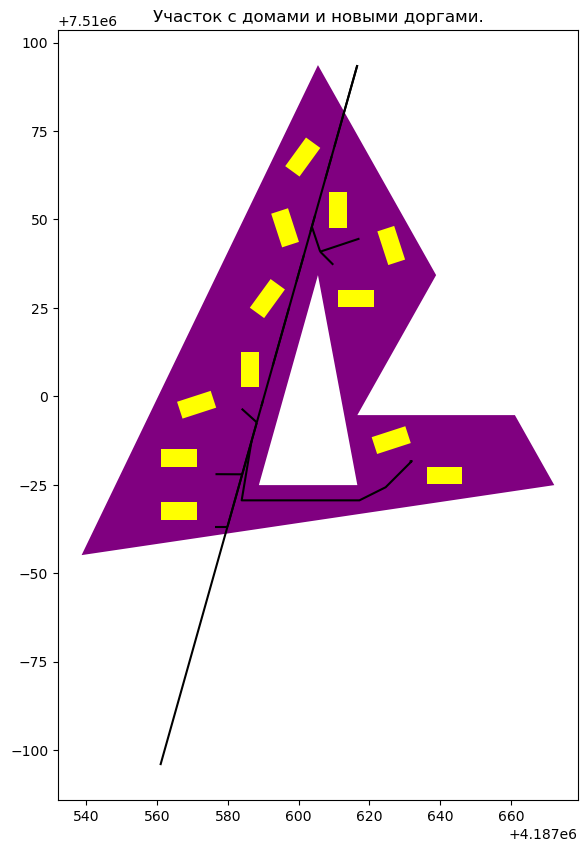

In [72]:
fig, ax = plt.subplots(1, figsize=(10,10))
AVAREA.plot(ax=ax, facecolor='purple')
placed_builds.plot(ax=ax, facecolor='yellow')
#gpd.GeoDataFrame({'name': 'buildings', 'restriction': None, 'geometry': [RESTRICTED_ZONES]}).plot(ax=ax, edgecolor='red')
ROADS = ROADS.union(roads.geometry.union_all())
ROADS = gpd.GeoDataFrame(to_geoframe(ROADS, 'road'))
ROADS.plot(ax=ax, edgecolor='black')
plt.title("Участок с домами и новыми доргами.")
plt.show()

## <span style="color: blue;">Этап 4. Постройка парков</span>

### <span style="color: DarkRed;">Краткое описание алгоритма постройк парков</span>
* Парком называется квадрат. Причем минимальный размер стороны этого квадрата - задаваемый пользователем параметр
* Кроме того, программа должна знать максимально возможный процент парков на данной территории
* Строительство парков производится только на территории, доступной для строительства жилых домов
* Принцип работы алгоритма:

1. Задаем сетку
2. Перемешиваем ячейки
3. Проходимся по списку перемешанных ячеек. Определяем расстояние до ближайшего запрещенного участка - sq_side. Если можно построить квадрат со стороной не меньшей, чем требуется, то пытаемся расположть квадрат
4. Если не позволяет ограничение по максимально доступной для строительства парков площадью, то масштабируем сторону квадрата так, чтобы всю оставшуюся площадь отдать под этот парк
5. Если в начале очередной итерации выясняется, что больше ни одного парка построить не удастся, то прерываем цикл

<span style="color: DarkRed;">4.1.</span> Блок ограничений

In [89]:
min_dist_to_restrict = 2.  # минимально возможное расстояние от парка до других объектов
park_size = 2.  # минимальный размер стороны квадратного парка
parks_prcnt = 0.3  # максимальный процент занимаемой парками территории

<span style="color: DarkRed;">4.2.</span> Работа с геометрией

In [92]:
# запрещенные для парков зоны
del RESTRICTED_ZONES
RESTRICTED_ZONES = df[df['restriction'] == 'no_build'].geometry.union_all().buffer(min_dist_to_restrict)
del BUILDS_ZONE
BUILDS_ZONE = placed_builds.geometry.union_all().buffer(min_dist_to_restrict)
RESTRICTED_ZONES = RESTRICTED_ZONES.union(BUILDS_ZONE).union(ROADS.geometry.union_all()).buffer(3)

In [96]:
# разрешенные для парков зоны
available_area = df[(df['restriction'] != 'no_build')]
AVAILABLE_AREA = available_area.geometry.difference(RESTRICTED_ZONES, 'align=True').geometry.union_all()
RESTRICTED_ZONES = TOTAL_ZONE.difference(AVAILABLE_AREA).buffer(3)

<span style="color: DarkRed;">4.3.</span> Функция, располагающая парки

In [99]:
#In:
# restricts - максимальная площадь для парков и размер стороны парка (словарь)
# GRID_SIZE - размер шага сетки
#Out: 
# расположенные парки

def create_parks(restricts, GRID_SIZE):
    global RESTRICTED_ZONES
    area_available_for_parks = restricts['max_area']
    min_park_area = restricts['park_size']**2
    ALL_PARKS = Point()  # эта переменная будет хранить все построенные парки
    nodes = create_grid(AVAILABLE_AREA.bounds, GRID_SIZE)
    random.shuffle(nodes) #перемешиваем, чтобы более равномерно раскидать
    for node in nodes:
        if area_available_for_parks < min_park_area:
            break
        sq_side = node.distance(RESTRICTED_ZONES) * np.sqrt(2)
        if (sq_side < restricts['park_size']): # таким образом связана сторона квадрата и полудиагональ
            continue
        new_park = create_rectangle(node, sq_side, sq_side)
        if new_park.intersects(ALL_PARKS):
            continue
        cur_area = sq_side ** 2
        if cur_area > area_available_for_parks: # мы точно знаем, что может поместиться хотя бы один парк. Значит просто делаем 
                                                    # размер квадрата таким, чтобы он вместился
            sq_side = sq_side * np.sqrt(area_available_for_parks / cur_area)
            new_park = create_rectangle(node, sq_side, sq_side)
            cur_area = area_available_for_parks
        ALL_PARKS = ALL_PARKS.union(new_park)
        area_available_for_parks -= cur_area
    return ALL_PARKS

<span style="color: DarkRed;">4.4.</span> Блок, запускающий строительство парков

In [102]:
GRID_SIZE = math.sqrt(AVAILABLE_AREA.area / 2000)
print(GRID_SIZE)
available_area = AVAILABLE_AREA.area
restricts = {'park_size': park_size, 'max_area': parks_prcnt * AREA} # AREA - общая площадь доступного участка,
                                                                                #  была определена раньше
placed_parks = create_parks(restricts, GRID_SIZE)
placed_parks = gpd.GeoDataFrame(to_geoframe(placed_parks, 'parks'))

0.9823718986512555


## <span style="color: blue;">Этап 5. Конечный результат</span>

### <span style="color: DarkRed;">5.1.</span> Визуализируем (фиолетовая зона - доступная территория, желтые прямоугольники - дома, зеленые квадраты - парки, синяя зона - запрещенные зоны ('no_build'))

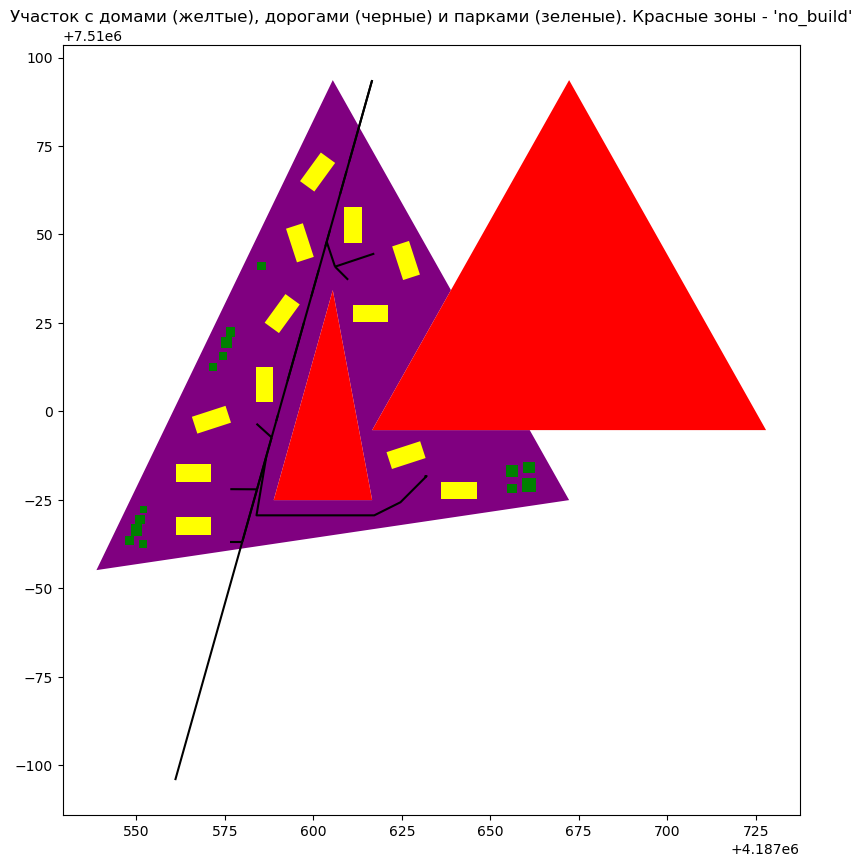

In [155]:
fig, ax = plt.subplots(1, figsize=(10,10))
AVAREA.plot(ax=ax, facecolor='purple')
placed_builds.plot(ax=ax, facecolor='yellow')
placed_parks.plot(ax=ax, facecolor='green')
ROADS.plot(ax=ax, edgecolor='black')
df[(df['restriction'] == 'no_build') & (df['name'] != 'Дорога')].plot(ax=ax, facecolor='red')
plt.title("Участок с домами (желтые), дорогами (черные) и парками (зеленые). Красные зоны - 'no_build'")
plt.savefig("/home/ivantozavr/job/result.png")
plt.show()

### <span style="color: DarkRed;">5.2.</span> А теперь записываем все в файл 

In [142]:
available_area_to = gpd.GeoDataFrame(to_geoframe(AVAREA.geometry.union_all(), 'available_zone'))

In [144]:
import pandas as pd
all = gpd.GeoDataFrame(pd.concat( [available_area_to, placed_builds, ROADS, placed_parks], ignore_index=True) )
all.crs = "EPSG:3857"

In [146]:
all.to_file("result.geojson", driver="GeoJSON")